In [1]:
import gzip
import glob
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

aa=['GLYD', 'SCA', 'SCV', 'SCL', 'SCI', 'SCP', 'SCHD', 'SCHE', 'SCHP', 'SCW', 'SCY', 'SCYM', 'SCM',
    'SCC', 'SCCM', 'SCF', 'SCS', 'SCT', 'SCK', 'SCKN', 'SCR', 'SCRN', 'SCE', 'SCEN', 'SCD',
    'SCDN','SCQ', 'SCN']

PMF='../../supp_files/popc/pmfs/'
PMF_data='../data/pmf-data/'

In [2]:
def free_energy(pKa, charge):
    R=8.314*10**(-3) #kJ/mol.K
    T=302.3545798089109 #K
    pH=7.0
    return -charge*R*T*np.log(10)*(pKa-pH)

def get_ref_per_acid(acid):
    #https://www.vanderbilt.edu/AnS/Chemistry/Rizzo/stuff/AA/AminoAcids.html
    # Pour la ref aux residus chargés
    #neutrals=['SCHE', 'SCHD', 'SCKN', 'SCRN', 'SCDN', 'SCEN', 'SCC']
    #pKas=[6.04, 6.04, 10.54, 12.48, 3.90, 4.07, 8.37]
    #charges=[1, 1, 1, 1, -1, -1, -1]
    # Pour la ref aux résidus non-chargés
    neutrals=['SCHP', 'SCKN', 'SCRN', 'SCDN', 'SCEN', 'SCCM', 'SCYM']
    pKas=[6.04, 10.54, 12.48, 3.90, 4.07, 8.37, 10.46]
    charges=[1, -1, -1, 1, 1, -1, -1]
    #dfref=extract_all_density(acid, file_path)
    #zero=stats_df['mean'].iloc[55]
    #zero=dfref['density{}{}'.format(traj, i)].values[55]+e #if per traj
    if acid in neutrals:
        zero_ref=free_energy(pKas[neutrals.index(acid)], charges[neutrals.index(acid)])
    else:
        zero_ref=0
    return zero_ref

def PMF_residue(acid):
    dfpmf=pd.read_table(PMF+f'{acid}.dat'.lower(), sep="\s+")
    return dfpmf



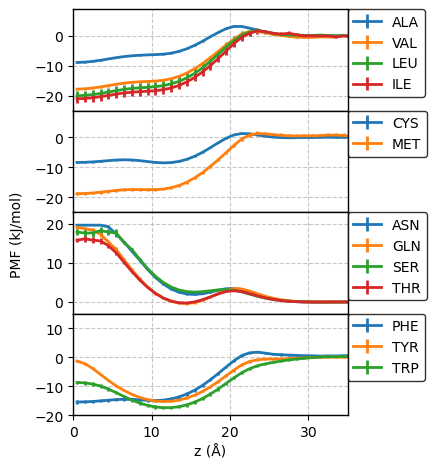

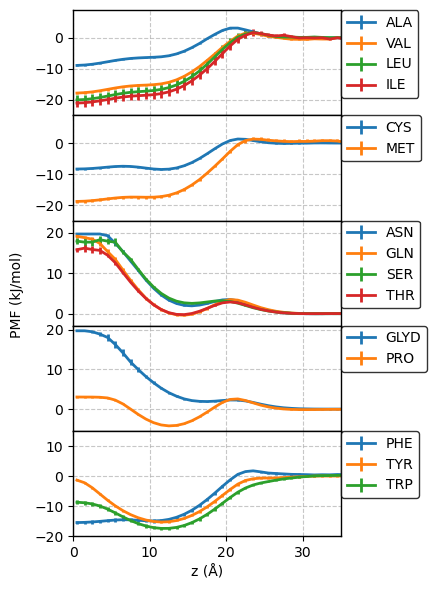

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_independent_graphs(acid_list, label_list, x_grid_interval=10, y_grid_interval=10):
    """
    Affiche des graphiques indépendants pour les PMF (ou profils de densité moyennés) d'acides.

    Paramètres:
      acid_list, label_list : listes imbriquées définissant pour chaque graphique indépendant
                              les acides et les labels correspondants.
                              Exemple pour 2 graphiques indépendants :
                                acid_list  = [['acid1', 'acid2'], ['acid3', 'acid4']]
                                label_list = [['label1', 'label2'], ['label3', 'label4']]
      x_grid_interval : int (défaut: 10)
                          Intervalle pour la grille verticale sur l'axe des abscisses.
      y_grid_interval : int (défaut: 10)
                          Intervalle pour la grille horizontale sur l'axe des ordonnées.
    """
    # Parcourir chaque groupe d'acides et leurs labels correspondants
    for group_acids, group_labels in zip(acid_list, label_list):
        fig, ax = plt.subplots(figsize=(5, 2))
        # Pour chaque acide dans le groupe, extraire les données et tracer sa courbe moyenne
        for acid, label in zip(group_acids, group_labels):
            # Extraction des données de pmf pour cet acide
            data = PMF_residue(acid)
            # Calcul de la courbe moyenne : moyenne de toutes les colonnes de densité, sauf '#z'
            #avg_curve = data.drop(columns=['#z']).mean(axis=1)
            x, y, e =data['x'], data['PMF_mean'], data['std_error']
            ax.errorbar(x, y, e, label=label, lw=2)
        
        # Configuration de la grille verticale et horizontale
        ax.xaxis.set_major_locator(ticker.MultipleLocator(x_grid_interval))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(y_grid_interval))
        ax.grid(True, which='major', linestyle='--', alpha=0.7)
        ax.set_xlim(0,35)
        
        # Ajout des labels et de la légende
        ax.set_xlabel("z (Å)")
        ax.set_ylabel("PMF (kJ/mol)")
        if group_labels[0] == 'CYS':
            ax.legend(loc='lower right', fontsize=8)
        else:
            ax.legend(fontsize=8)
        
        # Affichage du graphique
        plt.savefig('{}.png'.format(label), bbox_inches='tight', dpi=800, transparent=True)
        plt.show()


def plot_combined_graphs(acid_list, label_list, name, x_grid_interval=10, y_grid_interval=10):
    """
    Affiche des graphiques combinés en une seule colonne pour les PMF.
    
    Pour chaque sous-graphique, un groupe d'acides est tracé à partir des données extraites par
    extract_density(acid). Chaque courbe représente la moyenne des colonnes de densité (sauf '#z').
    
    Paramètres:
      acid_list, label_list : Listes imbriquées définissant, pour chaque sous-graphique, les acides
                              à combiner et leurs labels respectifs.
                              Exemple pour 2 sous-graphes combinés :
                                acid_list  = [['acid1', 'acid2'], ['acid3', 'acid4']]
                                label_list = [['label1', 'label2'], ['label3', 'label4']]
      x_grid_interval : int (défaut: 10)
                          Intervalle pour la grille verticale sur l'axe des abscisses.
      y_grid_interval : int (défaut: 10)
                          Intervalle pour la grille horizontale sur l'axe des ordonnées.
    """
    # Nombre de sous-graphes à créer (un par groupe d'acides)
    n_plots = len(acid_list)
    
    # Création des sous-graphes en une seule colonne, partageant le même axe x
    fig, axes = plt.subplots(n_plots, 1, sharex=True, figsize=(4.5, 1.2 * n_plots), gridspec_kw={'hspace': 0})
    fig.subplots_adjust(wspace=0, hspace=0)
    
    # Pour le cas d'un seul sous-graphe, s'assurer que axes est une liste
    if n_plots == 1:
        axes = [axes]
    
    # Parcours de chaque sous-graphique
    for ax, group_acids, group_labels in zip(axes, acid_list, label_list):
        # Pour chaque acide du groupe, extraire les données et tracer la courbe moyenne
        for acid, label in zip(group_acids, group_labels):
            # Extraction des données de pmf pour cet acide
            data = PMF_residue(acid)
            # Calcul de la courbe moyenne : moyenne de toutes les colonnes de densité, sauf '#z'
            #avg_curve = data.drop(columns=['#z']).mean(axis=1)
            x, y, e =data['x'], data['PMF_mean'], data['std_error']
            ax.errorbar(x, y, e, label=label, lw=2)
        
        # Configuration de la grille
        for spine in ax.spines.values():
            spine.set_linewidth(1)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(x_grid_interval))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(y_grid_interval))
        ax.grid(True, which='major', linestyle='--', alpha=0.7)
        ax.set_xlim(0,35)
        if 'CYS' in group_labels or 'ALA' in group_labels:
            ax.set_ylim(-25, 9)
            #ax.legend(fontsize=10, ncols=2, loc='lower right')
        elif 'THR' in group_labels:
            ax.set_ylim(-3, 23)
            #ax.legend(fontsize=10, ncols=2, loc='upper right')
        elif 'PHE' in group_labels:
            ax.set_ylim(-20, 15)
            #ax.legend(fontsize=10, ncols=3, loc='upper left')
        ax.legend(fontsize=10, ncols=1, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0., frameon=True, edgecolor='black', framealpha=0.8, markerscale=0.5)
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        # Optionnel : ajouter un titre ou d'autres réglages propres à chaque sous-graphique
        #ax.set_ylabel("PMF")
    
    # Label commun pour l'axe x pour l'ensemble de la figure
    axes[-1].set_xlabel("z (Å)", fontsize=10)
    # Label commun pour l'axe y à gauche
    fig.text(0.04, 0.5, "PMF (kJ/mol)", va='center', rotation='vertical', fontsize=10)
    
    plt.tight_layout(rect=[0.06, 0, 1, 1])  # Ajustement pour laisser de la place au label y commun
    plt.savefig('{}.png'.format(name), bbox_inches='tight', dpi=800, transparent=True)
    plt.show()

g1=['SCA', 'SCV', 'SCL', 'SCI']
g2=['SCC', 'SCM']
g3=['SCN', 'SCQ', 'SCS', 'SCT']
g4=['GLYD', 'SCP']
g5=['SCF', 'SCY', 'SCW']

l1=['ALA', 'VAL', 'LEU', 'ILE']
l2=['CYS', 'MET']
l3=['ASN', 'GLN', 'SER', 'THR']
l4=['GLYD', 'PRO']
l5=['PHE', 'TYR', 'TRP']

test1 = [g1, g2, g3, g5]
test2 = [g1, g2, g3, g4, g5]

label1 = [l1, l2, l3, l5]
label2 = [l1, l2, l3, l4, l5]


#plot_independent_graphs(test1, label1)
#plot_independent_graphs(test2, label2)

plot_combined_graphs(test1, label1, '4_graphics')
plot_combined_graphs(test2, label2, '5_graphics')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_2245/491626896.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2, 1].set_xticklabels(new_labels)


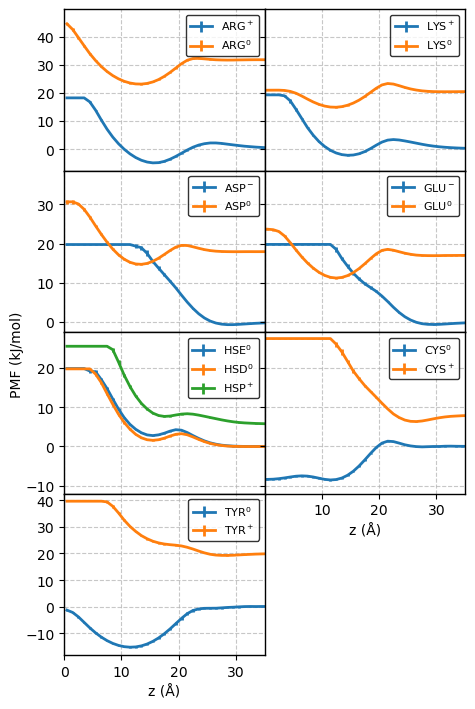

In [4]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

color = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_combined_graphs_2col(acid_list, label_list, name,
                              x_grid_interval=10, y_grid_interval=10):
    """
    Affiche des graphiques combinés en 2 colonnes pour les PMF.
    
    acid_list, label_list : listes imbriquées, un sous-groupe par graphe.
    """
    n_plots = len(acid_list)
    n_rows = math.ceil(n_plots / 2)
    
    # Création d'une grille n_rows x 2
    fig, axes = plt.subplots(n_rows, 2, sharex=False,
                             figsize=(5, 1.8 * n_rows),
                             gridspec_kw={'hspace': 0, 'wspace' : 0}, sharey="row")
    
    axes_flat = axes.flatten()

    for idx, (group_acids, group_labels) in enumerate(zip(acid_list, label_list)):
        ax = axes_flat[idx]
        for spine in ax.spines.values():
            spine.set_linewidth(1)
        for acid, label in zip(group_acids, group_labels):
            data = PMF_residue(acid)
            correction = get_ref_per_acid(acid)
            x, y, e = data['x'], data['PMF_mean']+correction, data['std_error']
            if acid=='GLYD':
                ax.errorbar(x, y, e, label=label, lw=2, color=color[2])
            elif acid=='SCP':
                ax.errorbar(x, y, e, label=label, lw=2, color=color[3])
            else:
                ax.errorbar(x, y, e, label=label, lw=2)
        if 'SCC' in group_acids:
            ax.set_ylim(-12, 29)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(x_grid_interval))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(y_grid_interval))
        ax.grid(True, which='major', linestyle='--', alpha=0.7)
        ax.set_xlim(0, 35)
        ax.legend(fontsize=8, edgecolor='black', framealpha=0.8)
        if idx!=5 and idx!=6:
            ax.tick_params(labelbottom=False)
    
    # Si nombre de plots impair, cacher l'axe vide
    if n_plots % 2 == 1:
        #axes_flat[-1].set_visible(False)
        axes_flat[-1].set_visible(True)
        axes_flat[-1].set_xticklabels(new_labels)
    axes_flat[5].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axes_flat[5].set_xlabel("z (Å)", fontsize=10)
    xticklabels = [label.get_text() for label in axes[2, 1].get_xticklabels()]
    new_labels = ["" if label == "0" else label for label in xticklabels]
    axes[2, 1].set_xticklabels(new_labels)
    axes_flat[6].set_xlabel("z (Å)", fontsize=10)


    # Labels communs
    fig.text(0.06, 0.5, "PMF (kJ/mol)",
             va='center', rotation='vertical', fontsize=10)
    fig.delaxes(axes_flat[7])
    
    plt.tight_layout(rect=[0.06, 0, 1, 1])
    plt.savefig(f'{name}.png',
                bbox_inches='tight', dpi=800, transparent=True)
    plt.show()


g1=['SCR', 'SCRN']
g2=['SCD', 'SCDN']
g3=['SCK', 'SCKN']
g4=['SCE', 'SCEN']
g5=['SCHE', 'SCHD', 'SCHP']
g6=['SCC', 'SCCM']
g7=['SCY', 'SCYM']
g8=['GLYD', 'SCP']

l1=['ARG$^+$', 'ARG$^0$']
l2=['ASP$^-$', 'ASP$^0$']
l3=['LYS$^+$', 'LYS$^0$']
l4=['GLU$^-$', 'GLU$^0$']
l5=['HSE$^0$', 'HSD$^0$', 'HSP$^+$']
l6=['CYS$^0$', 'CYS$^+$']
l7=['TYR$^0$', 'TYR$^+$']
l8=['GLYD', 'PRO']

test1 = [g1, g3, g2, g4, g5, g6, g7, []] #g8

label1 = [l1, l3, l2, l4, l5, l6, l7, []] #l8



plot_combined_graphs_2col(test1, label1, '8_graphics')


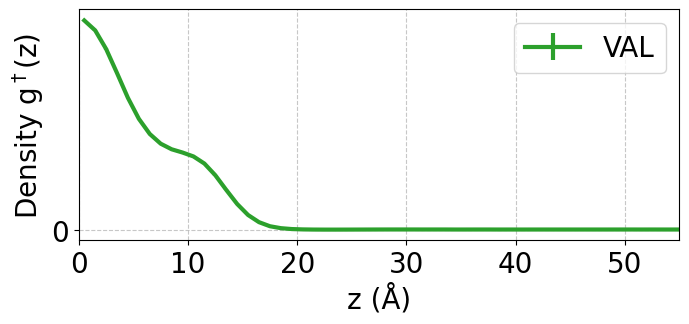

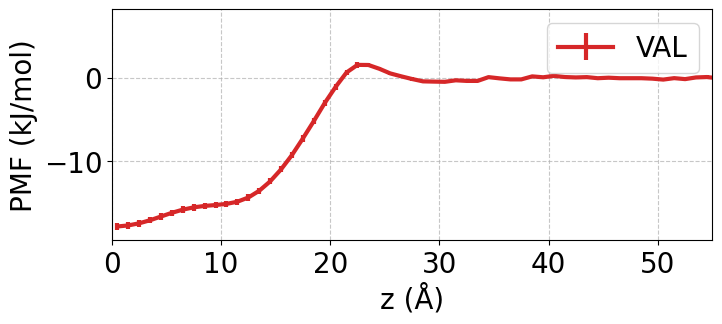

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

color = plt.rcParams['axes.prop_cycle'].by_key()['color']
fs=20

def plot_independent_graphs_v2(acid_list, label_list, plot_density=False, x_grid_interval=10, y_grid_interval=10):
    """
    Affiche des graphiques indépendants pour les PMF (ou profils de densité moyennés) d'acides.

    Paramètres:
      acid_list, label_list : listes imbriquées définissant pour chaque graphique indépendant
                              les acides et les labels correspondants.
                              Exemple pour 2 graphiques indépendants :
                                acid_list  = [['acid1', 'acid2'], ['acid3', 'acid4']]
                                label_list = [['label1', 'label2'], ['label3', 'label4']]
      x_grid_interval : int (défaut: 10)
                          Intervalle pour la grille verticale sur l'axe des abscisses.
      y_grid_interval : int (défaut: 10)
                          Intervalle pour la grille horizontale sur l'axe des ordonnées.
    """
    # Parcourir chaque groupe d'acides et leurs labels correspondants
    for group_acids, group_labels in zip(acid_list, label_list):
        fig, ax = plt.subplots(figsize=(7.75, 3))
        # Pour chaque acide dans le groupe, extraire les données et tracer sa courbe moyenne
        for acid, label in zip(group_acids, group_labels):
            if plot_density:
                all = pd.read_table(PMF_data+f'pmf_{acid}.dat'.lower(), sep="\s+")
                x=all['x']
                df_density = all[[f'y{i}_norm' for i in range(1,7)]]
                y, e = df_density.mean(axis=1), df_density.std(axis=1) / np.sqrt(df_density.shape[1])
                ax.errorbar(x, y, e, label=label, lw=3, color=color[2])
            else:
                # Extraction des données de pmf pour cet acide
                data = PMF_residue(acid)
                # Calcul de la courbe moyenne : moyenne de toutes les colonnes de densité, sauf '#z'
                #avg_curve = data.drop(columns=['#z']).mean(axis=1)
                x, y, e =data['x'], data['PMF_mean'], data['std_error']
                ax.errorbar(x, y, e, label=label, lw=3, color=color[3])
        
        # Configuration de la grille verticale et horizontale
        ax.xaxis.set_major_locator(ticker.MultipleLocator(x_grid_interval))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(y_grid_interval))
        ax.grid(True, which='major', linestyle='--', alpha=0.7)
        ax.tick_params(axis='both', labelsize=fs)
        ax.set_xlim(0,55)
        
        # Ajout des labels et de la légende
        if plot_density:
            ax.set_xlabel("z (Å)", fontsize=fs)
            ax.set_ylabel("Density g$^\dagger$(z)", fontsize=fs)
        else:
            ax.set_xlabel("z (Å)", fontsize=fs)
            ax.set_ylabel("PMF (kJ/mol)", fontsize=fs)
        if group_labels[0] == 'CYS':
            ax.legend(loc='lower right', fontsize=fs)
        else:
            ax.legend(fontsize=fs)
        """
        # Affichage du graphique
        if plot_density:
            plt.savefig('{}-ex_dens.png'.format(label), bbox_inches='tight', dpi=500, transparent=True)
        else:
            plt.savefig('{}-ex_pmf.png'.format(label), bbox_inches='tight', dpi=500, transparent=True)
        """
        plt.show()


g1=['SCV']
l1=['VAL']

test1 = [g1]

label1 = [l1]


#plot_independent_graphs(test1, label1)
plot_independent_graphs_v2(test1, label1, plot_density=True, x_grid_interval=10, y_grid_interval=1)
plot_independent_graphs_v2(test1, label1, plot_density=False)
